In [2]:
from NN import *
from LTL import *

from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis

import threading
import numpy as np
import os
from matplotlib import pyplot as plt

Number of Omega-automaton states (including the trap state): 55


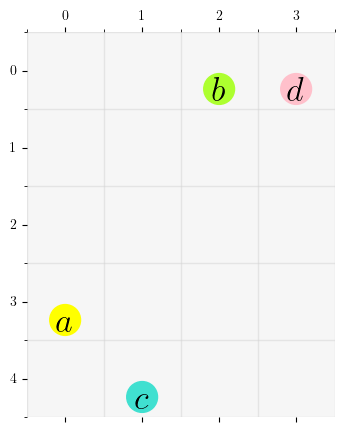

In [3]:
### from the Nursary case ###
# LTL Specification
# ltl = ('G ('
#     '(!d) & '
#     '((b & (!(X b)))->(X ((!b) U (a|c)))) & '
#     '(((!b) & (X b) & (!(X X b)))->((!a) U c)) & '
#     '(a->(X ((!a) U b))) & '
#     '(c->((!a) U b)) & '
#     '((b & (X b))->(F a))'
# ')')

ltl = ('G ('
    '(!d) & '
    '(c->((!a) U b)) & '
    '((b & (X b))->(F a)) & '
    '((b & (!(X b)))->(X ((!b) U (a|c)))) & '
    '(((!b) & (X b) & (!(X X b)))->((!a) U c)) &'
    '(a->(X ((!a) U b))) '
')')

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])

# MDP Description
shape = (5,4)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),    (),    ('b',),('d',)],
[(),    (),    (),    ()],
[(),    (),    (),    ()],
[('a',),(),    (),    ()],
[(),    ('c',),(),    ()]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'yellow',
    ('b',):'greenyellow',
    ('c',):'turquoise',
    ('d',):'pink'
}
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=0.8, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

In [4]:
model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 4, 55)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 5, 4, 32)     7072        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 4, 8)      1032        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 160)          0           ['conv2d_1[0][0]']               
                                                                                              

In [5]:
full_t = "[] ( (~d) /\ ((b /\ ~>b) -> >(~b % (a \/ c))) /\ (a -> >(~a % b))"
full_t += " /\ ((~b /\ >b /\ ~>>b)->(~a % c)) /\ (c->(~a % b)) /\ ((b /\ >b) -> <>a) )"

LTL_formula = parser.parse(full_t)
predicates={'a':[12], 'b':[2], 'c':[17], 'd':[3]}

### proof of satifying trajectory ###
tra = [17,13,9,5,1,2,6,10,14,18,17]
# print(len(tra), check_LTL(LTL_formula, tra, predicates))
#######

In [6]:
LTL_formula

('[]',
 ('/\\',
  ('~', (None, 'd')),
  ('/\\',
   ('->',
    ('/\\', (None, 'b'), ('~', ('>', (None, 'b')))),
    ('>', ('%', ('~', (None, 'b')), ('\\/', (None, 'a'), (None, 'c'))))),
   ('/\\',
    ('->', (None, 'a'), ('>', ('%', ('~', (None, 'a')), (None, 'b')))),
    ('/\\',
     ('->',
      ('/\\',
       ('~', (None, 'b')),
       ('/\\', ('>', (None, 'b')), ('~', ('>', ('>', (None, 'b')))))),
      ('%', ('~', (None, 'a')), (None, 'c'))),
     ('/\\',
      ('->', (None, 'c'), ('%', ('~', (None, 'a')), (None, 'b'))),
      ('->',
       ('/\\', (None, 'b'), ('>', (None, 'b'))),
       ('<>', (None, 'a')))))))))

In [7]:
model(csrl.ch_states[(0,0,0,0)][np.newaxis])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [10]:
num_epochs = 50
training = False
T = 20
results = []
threads = []
t_count = 0
search_depths = [2,4,8,16,32,40,60,80,100,120,140,160,180,200] #[2,4,6,8,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120]

for sd in search_depths:
    wins = 0
    N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)
    for epoch in range(num_epochs):
        t_count += 1
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                N = N, W = W, Q = Q, P = P, C=3, tow=1, n_samples=sd,
                verbose=0,start=(4,1),T=T,K=3)
        if check_LTL(LTL_formula, trajectory, predicates)[0]:
            wins+=1
            print(t_count)
            # print(check_LTL(LTL_formula, trajectory, predicates))

        if training:
            x_train = np.array(channeled_states)
            y1_train = np.array(better_policy)
            y2_train = np.array(reward_history) + (check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
            model.fit(x_train[:-1], [y1_train, y2_train[:-1]], epochs=20, verbose=0)
    ###############################################################
    print("Wins:",wins,"/",num_epochs)
    print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    print("Actions:", action_history)
    results.append(wins)

5
Wins: 1 / 50
last reward: 0.0   | trajectory: [17, 18, 14, 18, 19, 18, 14, 13, 12, 13, 9, 10, 11, 15, 19, 15, 19, 18, 17, 13]
Actions: [1, 0, 3, 1, 3, 0, 3, 3, 1, 0, 0, 2, 1, 1, 0, 1, 3, 3, 0]
70
Wins: 1 / 50
last reward: 0.0   | trajectory: [17, 17, 16, 12, 13, 14, 18, 17, 16, 12, 8, 4, 0, 1, 1, 1, 0, 1, 2, 6]
Actions: [1, 3, 0, 2, 2, 1, 3, 3, 0, 0, 0, 0, 2, 0, 0, 3, 2, 2, 1]
116
137
Wins: 2 / 50
last reward: 0.0   | trajectory: [17, 18, 14, 10, 9, 5, 1, 2, 1, 5, 4, 8, 12, 13, 17, 13, 14, 15, 19, 19]
Actions: [1, 0, 0, 3, 0, 0, 2, 3, 1, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1]
161
170
171
181
185
188
194
195
196
198
Wins: 10 / 50
last reward: 0.0   | trajectory: [17, 17, 18, 19, 15, 14, 10, 6, 7, 11, 10, 6, 2, 2, 2, 1, 0, 4, 5, 9]
Actions: [1, 0, 2, 0, 3, 0, 0, 0, 3, 3, 0, 0, 0, 3, 3, 3, 1, 2, 1]
204
205
208
212
214
215
234
238
239
240
Wins: 10 / 50
last reward: 0.0   | trajectory: [17, 17, 18, 18, 18, 17, 13, 9, 8, 4, 4, 5, 1, 2, 2, 6, 10, 14, 13, 9]
Actions: [1, 2, 3, 1, 3, 0, 0, 3, 0, 0, 2,

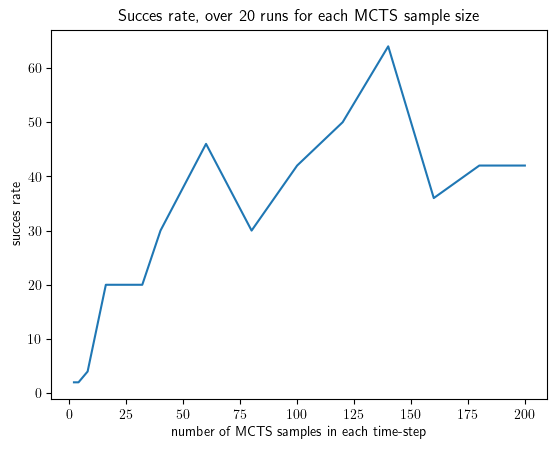

In [11]:
plt.plot(search_depths, [r*2 for r in results])
plt.xlabel("number of MCTS samples in each time-step")
plt.ylabel("succes rate")
plt.title("Succes rate, over 20 runs for each MCTS sample size")
plt.savefig('line_plot2.pdf')

In [19]:
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

In [25]:
def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:], save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=T-1)
interact(plot_agent,t=t)

interactive(children=(IntSlider(value=0, description='t', max=19), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_agent(t)>

NameError: name 'threading' is not defined

In [ ]:
os.system('ffmpeg -r 3 -i ./test/%d.png -vcodec libx264 -y ./test/test.mp4')

1

In [35]:
res = []
def ttt(x):
    res.append(x**2)
t1 = threading.Thread(target=ttt, args=(5,))
print(res)

start: None
join: None
[25]
